# General Analysis

This notebook contains a general analysis workflow for spicy-snow data that is designed to be applied anywhere in the western US. 

In [1]:
# import required packages
# depending on your environment, you may need to install some of these
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import dask
import geopandas as gpd
import rasterio as rio
import datetime as dt
import requests
import pandas as pd
import sys
import contextily as cx

### Load and prepare spicy snow depth data

In [2]:
# open spicy dataset as xarray dataset
dask.config.set({"array.slicing.split_large_chunks": False})
ds = xr.open_mfdataset(glob.glob('./data/sd_2020-08-01_2021-07-31.nc'))

# select snow depth and reproject to utm 
sd_da = ds.snow_depth.transpose('time', 'y', 'x')
crs = sd_da.rio.estimate_utm_crs()
sd_da = sd_da.rio.reproject(crs)

# open aoi geojson as geopandas dataframe and reproject
aoi_fn = './east_river_basin_wgs.geojson'
aoi_gdf = gpd.read_file(aoi_fn).to_crs(crs)

# clip data array to aoi
sd_da = sd_da.rio.clip(aoi_gdf.geometry, crs=aoi_gdf.crs, drop=False)

## Data exploration

### Load SNOTEL data

In [3]:
def get_awdb_data(
    site_ids,
    server,
    elements=["TAVG","SNWD","WTEQ"],
    sdate=dt.datetime(1899, 10, 1),
    edate=dt.datetime.today() - dt.timedelta(days=1),
    orient="records",
    sesh=None,
):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    Valid elements include WTEQ, SNWD, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    # Create an emply list to hold the dataframe output
    dfs = []
    # Incase only one site id is passed as a string, this will put it in a list
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    # Iterate over the site ids
    for site_id in site_ids:
        # Iterate over each of the elements (TAVG, WTEQ, SNWD)
        for element in elements:
            # this determines what data we will grab, daily data in this case
            endpoint = "data/getDaily"
            # This next few lines builds the API request
            date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
            frmt_args = f"format=json&orient={orient}"
            all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
            url = f"{server}/{endpoint}{all_args}"
            # This prints output to tell us what we are working on building
            print(
                f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} "
                f"and ending {edate:%Y-%m-%d}"
            )
            # This builds the column names
            data_col_lbl = f"{element}"
            # This makes the actual API requests
            if sesh:
                req = sesh.get(url)
            else:
                req = requests.get(url)
            if req.ok:
                df = pd.DataFrame.from_dict(req.json())
                df.columns = [data_col_lbl,"Date"]
                df.set_index("Date", inplace=True)
            else:
                print("  No data returned!")
                df = (
                    pd.DataFrame(
                        data=[{"Date": pd.NaT, data_col_lbl: np.nan}],
                    )
                    .set_index("Date")
                    .dropna()
                )
            # Append the dataframe that was built and return
            dfs.append(df)
        if return_single:
            return dfs[0]
    return dfs

In [4]:
def grab_snotel(aoi_gdf,
                buffer=1000,
                elements=["TAVG","SNWD","WTEQ"]
):
    '''
    Takes a geodataframe containing an area of interest and returns SNOTEL data from 
    stations within some distance of that area of interest. Geodataframe assumed to 
    be projected in appropriate utm zone. 
    '''
    # get SNTL data using an API built by Beau Uriona
    AWDB_API_DOMAIN = "https://api.snowdata.info"

    # pull in metadata for all NRCS SNOTEL sites
    sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
    sntl_gdf = gpd.read_file(sntl_meta_url).to_crs(aoi_gdf.crs)

    # find sites within some distance of aoi
    buf_gdf = aoi_gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    sntl_gdf = gpd.overlay(sntl_gdf, buf_gdf, how='intersection')
    
    # raise error if no site are found
    if sntl_gdf.empty:
        raise Exception(f'No SNOTEL sites within {buffer}m of aoi. Try a larger buffer.') 
    
    # build dict with station names and ids
    site_ids = list(sntl_gdf.stationTriplet)
    
    # download snotel data
    sntl_dfs = get_awdb_data(site_ids, server=AWDB_API_DOMAIN)
    
    # Make the index a datetime
    for i,df in enumerate(sntl_dfs):
        df.index = pd.to_datetime(df.index)
        sntl_dfs[i] = df

    # create a dictionary for conversion to xarray
    sntl_df_dict = {}
    counter = 0
    for i, site in enumerate(site_ids):
        sntl_df_dict[site_ids[i]] = pd.concat(sntl_dfs[counter:counter+len(elements)], 
                                              axis=1).sort_index().to_xarray()
        counter+=len(elements)
    
    # convert to xarray
    sntl_ds = xr.concat(sntl_df_dict.values(), pd.Index(sntl_df_dict.keys(), name='Location'))
    
    return sntl_ds, sntl_gdf

In [5]:
# get snotel data
sntl_ds, sntl_gdf = grab_snotel(aoi_gdf)
# convert to meters
sntl_ds['SNWD'] = sntl_ds['SNWD']*0.0254

getting data for 380:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-18
getting data for 380:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-18
getting data for 380:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-18
getting data for 737:CO:SNTL TAVG starting 1899-10-01 and ending 2023-05-18
getting data for 737:CO:SNTL SNWD starting 1899-10-01 and ending 2023-05-18
getting data for 737:CO:SNTL WTEQ starting 1899-10-01 and ending 2023-05-18


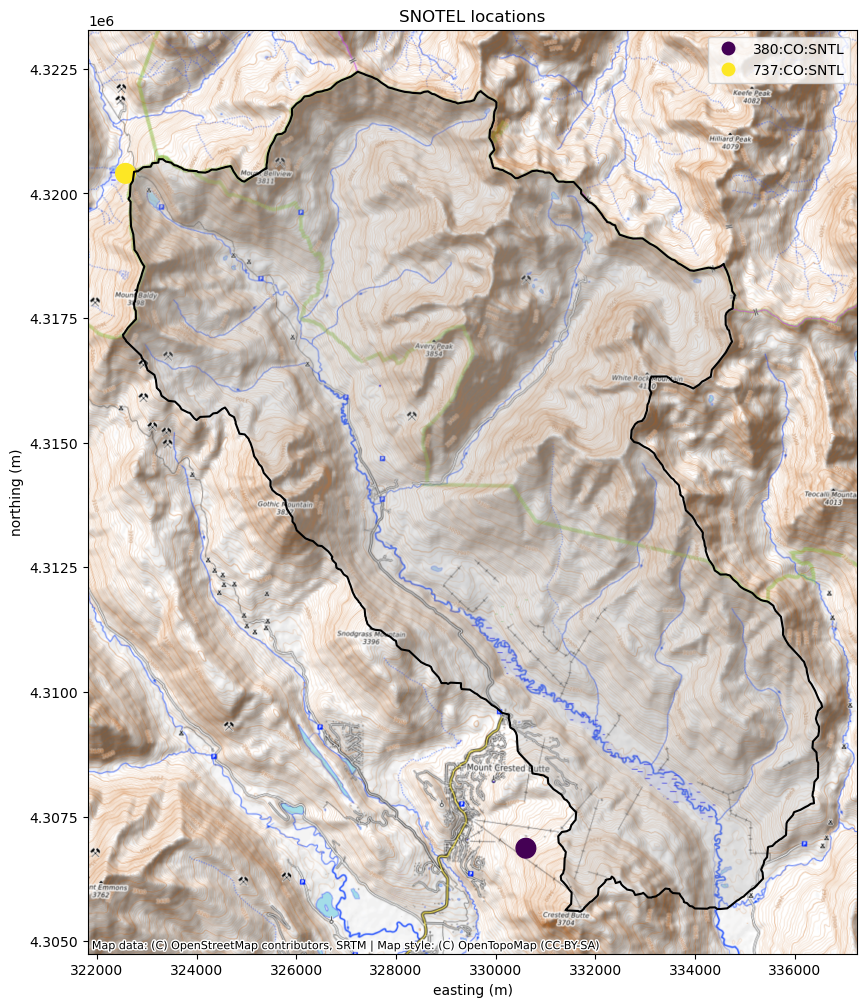

In [6]:
# Initialize Figure
f, ax = plt.subplots(figsize=(12,12))
# Plot aoi polygon
aoi_gdf.plot(ax=ax,
             color='darkgrey',
             alpha=0.3,
             zorder=1)
aoi_gdf.boundary.plot(ax=ax,
                      color='k')
# Plot SNTL locations
sntl_gdf.plot(markersize=200,
              ax=ax,
              column=sntl_gdf.stationTriplet,
              cmap='tab10',
              legend=True)

cx.add_basemap(ax=ax, crs=aoi_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('easting (m)');
ax.set_ylabel('northing (m)');
ax.set_title('SNOTEL locations');

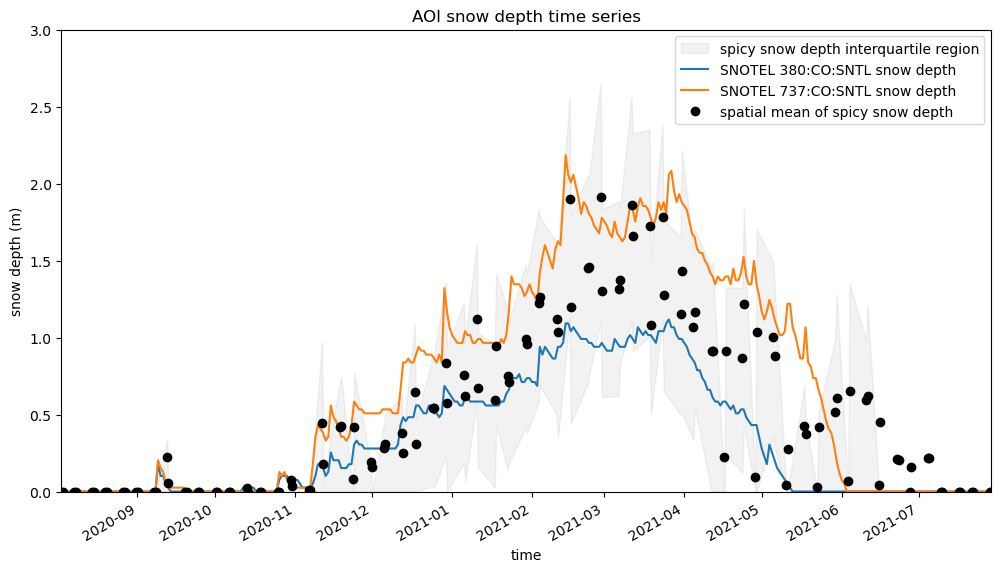

In [7]:
# plot snow depth time series
f, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(sd_da.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').time,
                sd_da.quantile(q=0.25, dim=['x', 'y']).dropna(dim='time').values,
                sd_da.quantile(q=0.75, dim=['x', 'y']).dropna('time').values,
                alpha=0.1, color='Grey', label='spicy snow depth interquartile region')
for site in sntl_ds.Location:
    sntl_ds.sel(Location=site).SNWD.plot(label=f'SNOTEL {site.values} snow depth')
sd_da.mean(dim=['x', 'y']).plot(marker='o', linestyle='', c='k', label='spatial mean of spicy snow depth')
ax.set_xlim(sd_da.time[0], sd_da.time[-1])
ax.set_ylim(0, 3)
ax.set_ylabel('snow depth (m)')
ax.legend()
ax.set_title('AOI snow depth time series')

plt.savefig('./figs/sd_ts.png', dpi=300)

In [8]:
# select SNOTEL measurements during Sentinel-1 overpass
sntl_ds_overpass = sntl_ds.sel(Date=sd_da.time, method='nearest')

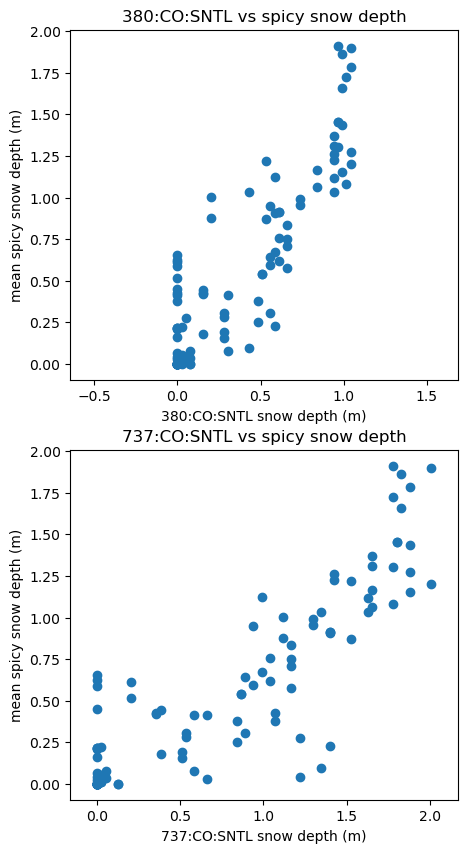

In [9]:
# plot spicy vs snotel snow depths
f, ax = plt.subplots(len(sntl_ds.Location), 1, figsize=(5, len(sntl_ds.Location)*5))
for i, site in enumerate(sntl_ds.Location):
    ax[i].scatter(sntl_ds_overpass.sel(Location=site).SNWD, sd_da.mean(dim=['x', 'y']))
    ax[i].set_aspect('equal', 'datalim')
    ax[i].set_title(f'{site.values} vs spicy snow depth')
    ax[i].set_xlabel(f'{site.values} snow depth (m)')
    ax[i].set_ylabel('mean spicy snow depth (m)')
    
plt.savefig('./figs/snotelvspicy.png', dpi=300)

### Load stream gauge data

In [10]:
# install USGS stream data retrieval package
!{sys.executable} -m pip install dataretrieval

In [11]:
import dataretrieval.nwis as nwis

In [27]:
# function to get bbox around aoi
def gage_bbox(gdf, buffer=15000):
    buf_gdf = gdf.copy(deep=True)
    buf_gdf['geometry'] = buf_gdf.buffer(buffer)
    bbox = [round(elem, 3) for elem in buf_gdf.to_crs(4326).bounds.values[0].tolist()]
    return bbox

In [28]:
bbox = gage_bbox(aoi_gdf)
# search for stream sites in the vicinity 
nwis_df = nwis.get_info(bBox=bbox,
                        siteType='ST',
                        startDT=sd_da.time[0].dt.strftime('%Y-%m-%d').item(),
                        endDT=sd_da.time[-1].dt.strftime('%Y-%m-%d').item())[0]

nwis_gdf = gpd.GeoDataFrame(
    nwis_df, geometry=gpd.points_from_xy(nwis_df.dec_long_va, nwis_df.dec_lat_va), crs="EPSG:4326").to_crs(crs)

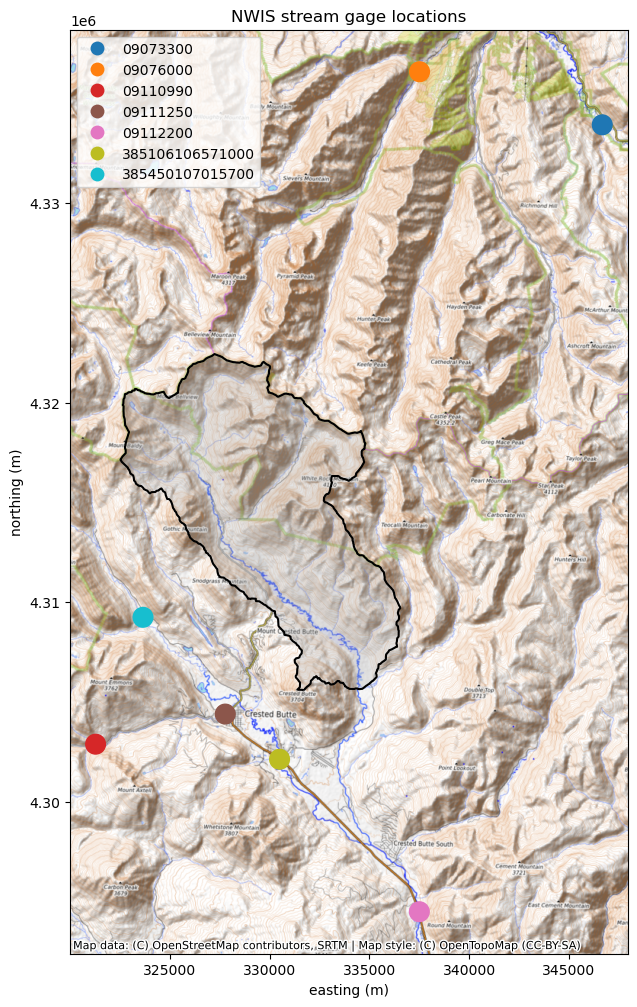

In [33]:
# Initialize Figure
f, ax = plt.subplots(figsize=(12,12))
# Plot aoi polygon
aoi_gdf.plot(ax=ax,
             color='darkgrey',
             alpha=0.3,
             zorder=1)
aoi_gdf.boundary.plot(ax=ax,
                      color='k')
# Plot SNTL locations
nwis_gdf.plot(markersize=200,
              ax=ax,
              column=nwis_gdf.site_no,
              cmap='tab10',
              legend=True)

cx.add_basemap(ax=ax, crs=aoi_gdf.crs.to_string(), source=cx.providers.OpenTopoMap);
ax.set_xlabel('easting (m)');
ax.set_ylabel('northing (m)');
ax.set_title('NWIS stream gage locations');

For now, need to manually decide which stream gages are of interest for your aoi. 

In [16]:
nwis.get_record(service='dv', start='2020-08-01', end='2021-07-31', bBox=bbox)

00010_Maximum 00010_Maximum_cd   
site_no         datetime                                                    
09073300        2020-08-01 00:00:00+00:00            NaN              NaN  \
                2020-08-02 00:00:00+00:00            NaN              NaN   
                2020-08-03 00:00:00+00:00            NaN              NaN   
                2020-08-04 00:00:00+00:00            NaN              NaN   
                2020-08-05 00:00:00+00:00            NaN              NaN   
...                                                  ...              ...   
385106106571000 2021-07-27 00:00:00+00:00           22.0                A   
                2021-07-28 00:00:00+00:00           20.4                A   
                2021-07-29 00:00:00+00:00           20.3                A   
                2021-07-30 00:00:00+00:00           21.3                A   
                2021-07-31 00:00:00+00:00           19.3                A   

                                           00010_Minimum 00010_Minimum_cd   
site_no         datetime                                                    
09073300        2020-08-01 00:00:00+00:00            NaN              NaN  \
                2020-08-02 00:00:00+00:00            NaN              NaN   
                2020-08-03 00:00:00+00:00            NaN              NaN   
                2020-08-04 00:00:00+00:00            NaN              NaN   
                2020-08-05 00:00:00+00:00            NaN              NaN   
...                                                  ...              ...   
385106106571000 2021-07-27 00:00:00+00:00           13.1                A   
                2021-07-28 00:00:00+00:00           14.2                A   
                2021-07-29 00:00:00+00:00           13.2                A   
                2021-07-30 00:00:00+00:00           14.4                A   
                2021-07-31 00:00:00+00:00           12.5                A   

                                           00010_Mean 00010_Mean_cd   
site_no         datetime                                              
09073300        2020-08-01 00:00:00+00:00         NaN           NaN  \
                2020-08-02 00:00:00+00:00         NaN           NaN   
                2020-08-03 00:00:00+00:00         NaN           NaN   
                2020-08-04 00:00:00+00:00         NaN           NaN   
                2020-08-05 00:00:00+00:00         NaN           NaN   
...                                               ...           ...   
385106106571000 2021-07-27 00:00:00+00:00        17.5             A   
                2021-07-28 00:00:00+00:00        17.2             A   
                2021-07-29 00:00:00+00:00        17.1             A   
                2021-07-30 00:00:00+00:00        17.1             A   
                2021-07-31 00:00:00+00:00        15.5             A   

                                           00060_Mean 00060_Mean_cd  
site_no         datetime                                             
09073300        2020-08-01 00:00:00+00:00        24.6             A  
                2020-08-02 00:00:00+00:00        21.0             A  
                2020-08-03 00:00:00+00:00        48.7             A  
                2020-08-04 00:00:00+00:00        46.5             A  
                2020-08-05 00:00:00+00:00        42.8             A  
...                                               ...           ...  
385106106571000 2021-07-27 00:00:00+00:00        33.9             A  
                2021-07-28 00:00:00+00:00        32.5             A  
                2021-07-29 00:00:00+00:00        35.0             A  
                2021-07-30 00:00:00+00:00        59.7             A  
                2021-07-31 00:00:00+00:00        77.7             A  

[1857 rows x 8 columns]

In [ ]:
get_usgs_daily_gage_data(bbox=bbox, start_date='2021-11-10', end_date='2021-11-24')

In [ ]:
# get streamflow data for each gage and combine into a single dataframe
df = pd.concat([
    get_usgs_daily_gage_data(bbox=bbox, code='iv', start_date='2021-11-10', end_date='2021-11-24') 
    for gage in basin_gages.keys()
])